In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy.fftpack import fft, fftfreq
import scipy as sp
from scatseisnet import ScatteringNetwork

#import betterplot

from scipy import signal
import umap

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import butter, sosfiltfilt

from  matplotlib import ticker
mticker = ticker.ScalarFormatter(useOffset=False)


In [2]:
import proplot as pplt

def filter(x, freqmin = 1, freqmax = 10, fs = 40, order = 4):
    
    zeropole = signal.butter(order, (freqmin, freqmax), 'bp', fs=fs)

    fd = signal.filtfilt(zeropole[0], zeropole[1], x)
    
    return fd




In [3]:
freqmin = 1
freqmax = 8
sr = 40

reduce_type = np.mean

name_fig = 'FIGURE01_COMPARISION'

name = f"{name_fig}"

savepath = f"/bettik/dokhtdor/projects/scatnet4scatwaves/figures/{name}/"

os.makedirs(savepath, exist_ok=True)


In [4]:


FILEPATH = "/bettik/dokhtdor/projects/scatnet4scatwaves/data/dataset/"

vs_hr = np.load(FILEPATH+'vs_map_2400x1300.npy')
vs_hr = vs_hr/1000

vs = np.load(FILEPATH+'vs_array.npy') 
vs = vs/1000

data_records_vs = []
for i in range(1, 6):
    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/z_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/z_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_vs.append(data_read)
data_records_vs = np.array(data_records_vs) 

sos = butter(10, freqmax, 'lp', fs=40, output='sos')
data_records_vs = sosfiltfilt(sos, data_records_vs[:,:,:], axis=-1)
data_records_vs = np.concatenate(data_records_vs, axis = 1)
#data_records_vs = data_records_vs[:, :, ::2]

data_records_hs = []
for i in range(1, 6):    
    data_read = np.hstack([np.load(FILEPATH+f"vert{i}/x_r_s{i}.npy")[:, np.newaxis,:], np.load(FILEPATH+f"horiz{i}/x_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_hs.append(data_read)
data_records_hs = np.array(data_records_hs)


sos = butter(10, freqmax, 'lp', fs=40, output='sos')
data_records_hs = sosfiltfilt(sos, data_records_hs[:,:,:], axis=-1)
data_records_hs = np.concatenate(data_records_hs, axis = 1)
#data_records_hs = data_records_hs[:, :, ::2]



In [5]:

indx = [15, 35, 55, 75, 95]


In [6]:
sr = 40


from scatseisnet import ScatteringNetwork

segment_duration_seconds = data_records_vs.shape[-1]/sr

sampling_rate_hertz = sr


samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)

bank_keyword_arguments = (
        {"octaves": 4, "resolution": 8, "quality": 2, "normalize_wavelet": 'l2'},
        {"octaves": 5, "resolution": 5, "quality": 2, "normalize_wavelet": 'l2'},
        )    

network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)

# for i, bank in enumerate(network.banks):
#     print(f"Bank {i}")
#     print(bank)
#     for j in range(bank.wavelets.shape[0]):
#         network.banks[i].wavelets[j] = network.banks[i].wavelets[j] / ((np.abs(network.banks[i].wavelets[j])**2).sum())

# network.banks[0].spectra = np.fft.fft(network.banks[0].wavelets)
# network.banks[1].spectra = np.fft.fft(network.banks[1].wavelets)



ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=2, sampling_rate=40, len=32)
ComplexMorletBank(bins=1500, octaves=5, resolution=5, quality=2, sampling_rate=40, len=25)


In [7]:
time = np.arange(0, data_records_vs.shape[-1], 1) / sr

indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]


In [8]:
segments = [data_records_vs[i,:,:] for i in indxvs[indx, 30]]


sc1 = network.transform(segments,  reduce_type= None )


sc1med = network.transform(segments,  reduce_type= np.median )

sc1mean = network.transform(segments,  reduce_type= np.mean )
sc1max = network.transform(segments,  reduce_type= np.max )


for i in range(len(network.banks[0].centers)):

    n = network.banks[0].centers[i] <= network.banks[1].centers  # Find the center of the wavelet in the second layer that is closest to the center of the wavelet in the first layer
    sc1mean[1][:,:, i, n] = np.nan
    sc1med[1][:,:, i, n] = np.nan
    sc1max[1][:,:, i, n] = np.nan

    

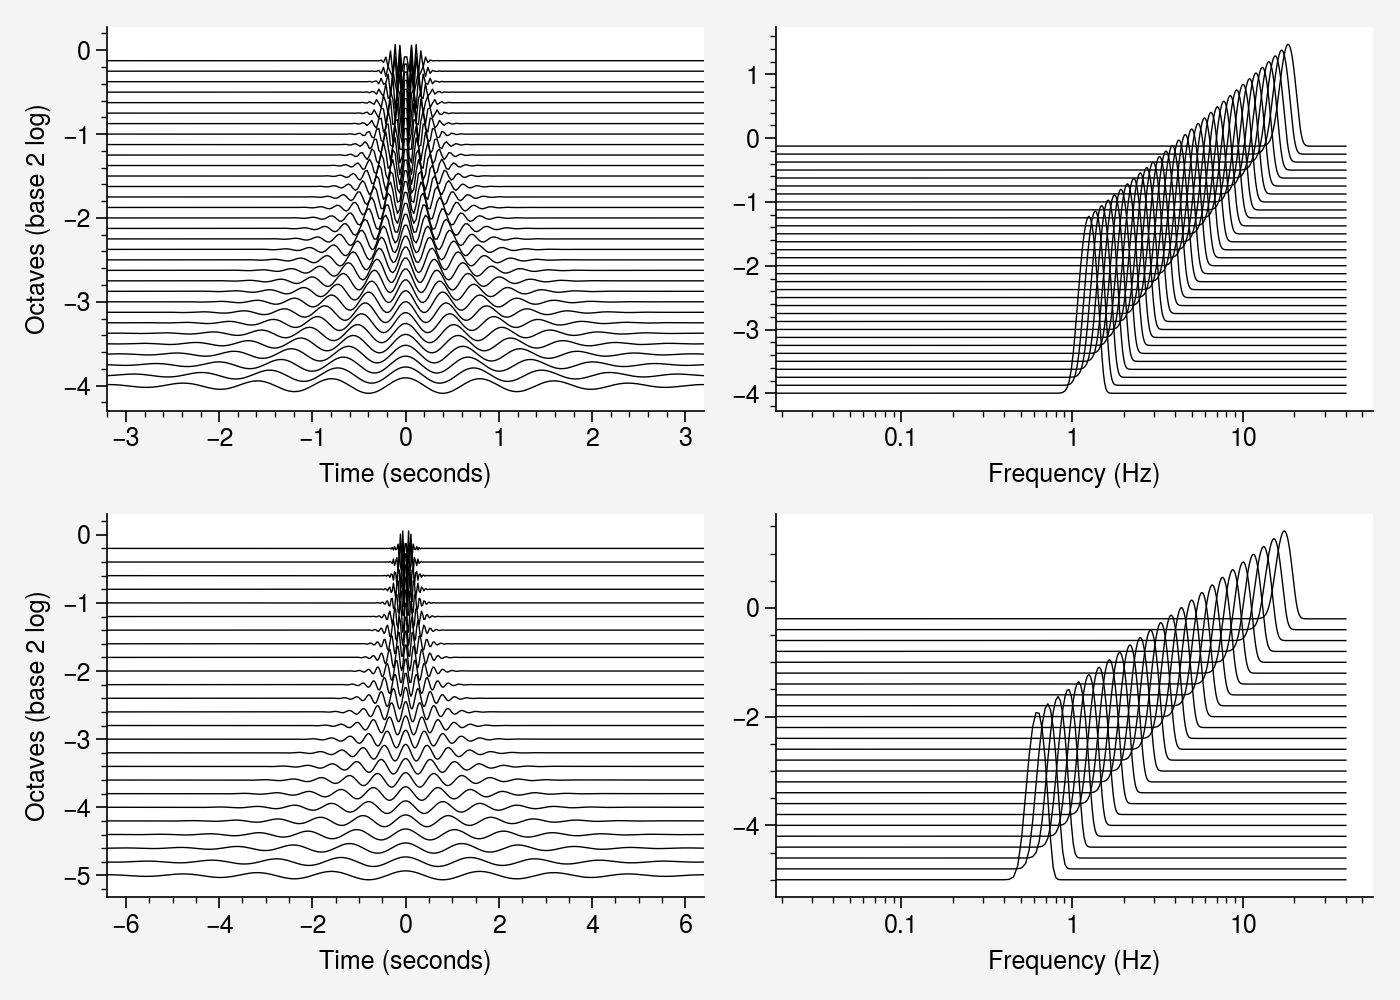

In [9]:


fig, ax = plt.subplots(2, 2, figsize=(7,5),  )


for i, bank in enumerate(network.banks):

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'k', lw = 0.5)

        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'k', lw = 0.5)

    width_max = 2 * bank.widths.max()

    # Labels
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()
    

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


    
fig.tight_layout()
#fig.savefig(savepath + f'filterbank.pdf', transparent=True, dpi = 300)


In [10]:
import seaborn as sns
trc = [0 , -1]

cmap2 = sns.color_palette("hls", 3)

print(cmap2.as_hex())

cmap2


['#db5f57', '#57db5f', '#5f57db']


[(0.86, 0.3712, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.3712, 0.33999999999999997, 0.86)]

In [11]:
import seaborn as sns

colors = sns.color_palette(n_colors=3)


cmap2 = sns.color_palette("rocket", as_cmap=True)
cmap3 = sns.color_palette("mako", as_cmap=True)


/tmp/ipykernel_1688619/1837914586.py:4: ProplotWarning: 'gridspec_kw' is not necessary in proplot. Pass the parameters as keyword arguments instead.
  ax = fig.subplots(ncols=2, nrows=4, gridspec_kw=gs)
/tmp/ipykernel_1688619/1837914586.py:117: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


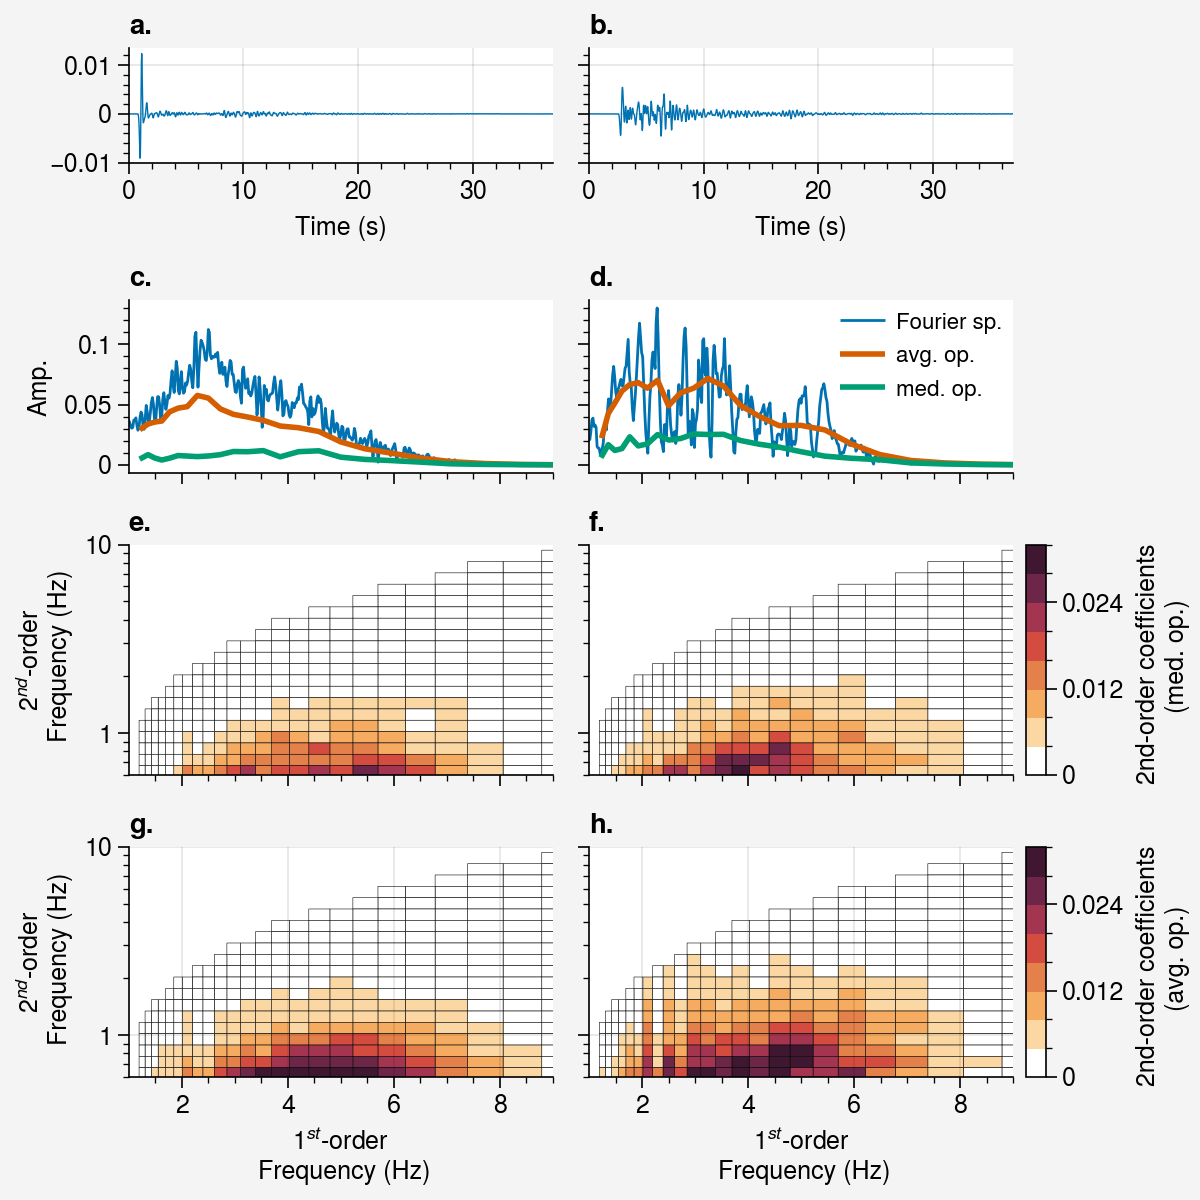

In [13]:

fig = pplt.figure( sharey=True, sharex=False, figsize = (6, 6), span=False)

gs = {"height_ratios": [1, 1.5, 2, 2]}
ax = fig.subplots(ncols=2, nrows=4, gridspec_kw=gs)


vmax = 0.028
nnn = network.banks[0].centers.shape[0]*2
iij = 0
ifig_caption = ['a.', 'b.', 'c.']
for i, ind in enumerate(trc):

    ax[i].plot(time, segments[ind][iij], lw = 0.5)
    #ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim(0, 37)



for i, ind in enumerate(trc):
    i = i + 2
    norm = sp.linalg.norm(abs(sp.fft.fft(segments[ind][iij], n = 2048))[:]*2)

    l1,  = ax[i].plot(np.fft.fftfreq(2048, 1/sr)[:1024], abs(sp.fft.fft(segments[ind][iij], n = 2048))[:1024], label = 'Fourier sp.',  lw = 1., alpha = 1)
    # axtwin = ax[i].twinx()
    # if i ==0: axtwin.set_yticklabels([])

     
    l2,  = ax[i].plot(network.banks[0].centers, (sc1mean[0][ind][iij])*nnn, lw =2, label = 'avg. op.', )
    l3,  = ax[i].plot(network.banks[0].centers, (sc1med[0][ind][iij])*nnn, lw = 2, label = 'med. op.',)
    
    ax[i].set_xlim(1, 9)
    #ax[i].set_title(ifig_caption[i], loc = 'left', fontweight = 'bold') 

#ax[i].legend(legend='ul',)

ax[i].legend(handles=[l1, l2, l3], ncol= 1, loc = 'upper right', fontsize = 8, frame= False)
# ax[0].set_ylabel("Scattering \n coefficients (order 1)")
# axtwin.set_ylabel('Amplitude')


ifig_caption = ['g.', 'h.', 'l.']  
for i, ind in enumerate(trc):
    i = i + 4
    nn = ((sc1med[1][ind, iij]).T)**0.5

    im1 = ax[i].pcolor(network.banks[0].centers, 
                       network.banks[1].centers, 
                       nn,
                       rasterized=True, 
                       edgecolors='k',
                       linewidths=0.2, 
                       vmin = 0, vmax = 0.035,

                 )
    
    #ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    #ax[i].grid(True)

    #ax[i].set_xlabel('1st order \n central frequency (Hz)')

    ax[i].set_xlim(1, 9)
    ax[i].set_ylim(0.6,10)

ax[i].colorbar(im1, width = 0.1, label='2nd-order coefficients \n (med. op.)')



ifig_caption = ['i.', 'j.', 'l.']  
for i, ind in enumerate(trc):
    i = i + 6
    
    nn = ((sc1mean[1][ind, iij]).T)**0.5
    nn = nn #- np.median(np.log(sc1mean[1]**1), axis = 0)[0].T
    
    im1 = ax[i].pcolor(network.banks[0].centers, 
                       network.banks[1].centers, 
                       nn,
                       rasterized=True, 
                       edgecolors='k', 
                       linewidths=0.2,
                       vmin = 0, 
                       vmax = 0.035,
                       )
    
    ax[i].set_yscale('log')
    ax[i].set_xlabel('f$_{1}$ (Hz)')

    ax[i].set_xlim(1, 9)
    ax[i].set_ylim(0.6,10)


ax[i].colorbar(im1, width = 0.1, label='2nd-order coefficients \n (avg. op.)')

ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')

ax[6].set_xlabel("$1^{st}$-order \n Frequency (Hz)")
ax[7].set_xlabel("$1^{st}$-order \n Frequency (Hz)")

ax[2].set_ylabel("Amp.")

ax[6].set_ylabel("$2^{nd}$-order \n Frequency (Hz)")
ax[4].set_ylabel("$2^{nd}$-order \n Frequency (Hz)")

ifig_caption = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.', 'i.', 'j.', 'k.', 'l.']
for i, axn in enumerate(ax):
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    axn.set_title(ifig_caption[i], loc = 'left', fontweight = 'bold') 

for axn in ax[2:6]:
    axn.format(grid=False, tickdir='out')
    axn.set_xticklabels('')
    
    
plt.tight_layout()
fig.savefig(savepath + f'Figure01_comparision.png', transparent=True, dpi = 300)
